In [1]:
# Trefor Evans (trefor.evans@mail.utoronto.ca)
% matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import itertools

We demonstrate the use of the sinkhorn operator as a continuous relaxation of the matching operatior which enables automatic differentiation. First we review the softmax operator for approximating a discrete category, then we introduce the sinkhorn as a dual for approximating a permutation.

# Softmax Relaxation
A sensible way to approximate a discrete category by continuous values is by using a temperature-dependent softmax function. We show here how the softmax function provides a relaxation to the argmax function and converges as the temperature goes to zero.
This was used as a continuous relaxation in the Concrete and Gumbel-softmax papers discussed earlier in the course.

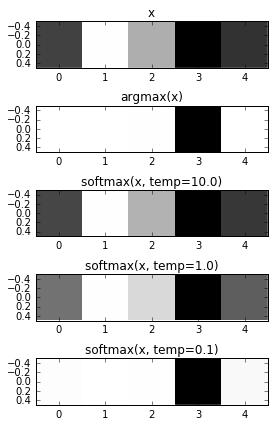

In [2]:
fig, ax_arr = plt.subplots(nrows=5, figsize=(6,6))

# plot the parameter matrix
np.random.seed(0)
n = 5
x = np.random.randn(1,n)
ax_arr[0].imshow(x, interpolation='none', cmap='gray_r')
ax_arr[0].set_title("x")

# plot the exact argmax function
ax_arr[1].imshow(x == x.max(), interpolation='none', cmap='gray_r')
ax_arr[1].set_title("argmax(x)")

# plot the softmax for varying temperatures
def softmax(x, temp=1.):
     return np.exp(x/temp) / np.sum(np.exp(x/temp))
for ax, temp in zip(ax_arr[2:], np.logspace(1,-1,num=len(ax_arr[2:]))):
    ax.imshow(softmax(x,temp), interpolation='none', cmap='gray_r')
    ax.set_title("softmax(x, temp=%.1f)"%temp)

fig.tight_layout()    

# Sinkhorn Relaxation
Now we want to learn permutations rather than a discrete category. We will demonstrate the use of the sinkhorn operator as a relaxation of the matching operator.

## The Matching operator
First, Generate a random parameter matrix X$\in \mathbb{R}^{n \times n}$ and plot along with the exact matching operator applied to X; M(X). 
Each row of X is the output of the same model (e.g. a CNN) with different pieces of the jigsaw puzzle fed in. 
You can consider each of these rows to be a vector of local likelihoods of location assignment. The matching operator then takes all these rows and makes them consistent.

Note that the matching operator is *not* differentiable! It searches over all $n!$ possible permutation matrices and returns the one with the maximum Frobinius inner product.

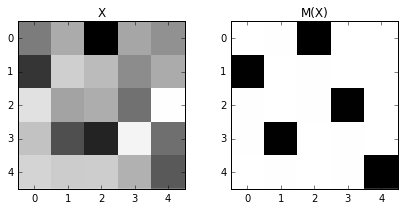

In [3]:
np.random.seed(5)
fig, ax_arr = plt.subplots(ncols=2, figsize=(7,3))

n = 5
X = np.random.randn(n,n)
ax_arr[0].imshow(X, interpolation='none', cmap='gray_r')
ax_arr[0].set_title("X")

def matching(X):
    """ matching operator """
    fprod_best = -np.inf 
    # generate all possible permutation matricies and assess them
    for perm in itertools.permutations(np.arange(X.shape[0])):
        P = np.identity(X.shape[0])[np.asarray(perm)]
        fprod = np.trace(P.T.dot(X)) # Frobinius inner product
        if fprod > fprod_best: # then save the best
            Pbest = P
            fprod_best = fprod
    return Pbest

ax_arr[1].imshow(matching(X), interpolation='none', cmap='gray_r')
ax_arr[1].set_title("M(X)");

## The Sinkhorn operator
Define the sinkhorn operator. Notice that this is differentiable!

In [4]:
def sinkhorn(X, L, temp=1.):
    """ Sinkhorn operator """
    if L==0:
        S = np.exp(X/temp)
    else:
        S = sinkhorn(X, L-1, temp)
        S = S / np.sum(S, axis=1, keepdims=True) # row normalize
        S = S / np.sum(S, axis=0, keepdims=True) # column normalize
    return S

Plot the sinkhorn operator applied to X for varying values of L and $\tau$. 

You can see that the sinkhorn operator converges to the matching operator as $L \rightarrow \infty$, $\tau \rightarrow 0$.

In [5]:
fig, ax_arr = plt.subplots(nrows=3, ncols=3, figsize=(10,10))
for i_row, L in enumerate([5,10,20]):
    for i_col, tau in enumerate([1,0.1,0.01]):
        ax = ax_arr[i_row,i_col]
        ax.imshow(sinkhorn(X, L, tau), 
                  interpolation='none', cmap='gray_r', vmin=0, vmax=1)
        ax.set_title("L=%d, temp=%.2f"%(L,tau))

# Sinkhorn Networks for Matching
We can formulate a supervised learning method to reconstruct a scrambled object from several training examples. 
Each row of $g(\tilde{X},\theta)$ are the unnormalized assignment probabilities from a CNN which is given a single piece of the jigsaw puzzle.
$S(\cdot)$ is the sinkhorn operator which makes the individual assignment probabilities consistent and as $\tau \rightarrow 0$, $S(g(\tilde{X},\theta)/\tau)$ is pushed to the vertex of the Birkhoff polytope to become identical to the matching operator $M(g(\tilde{X},\theta))$.

At test time, $M(g(\tilde{X},\theta))$ is used.
<img src="files/imgs/mnist_jigsaw.png">
(Image taken from figure 1 of paper)

# Gumbel-Sinkhorn Distribution
We would next like to be able to perform approximate posterior inference, so
we can parallel the choices made in the Concrete & Gumbel-Softmax papers to enable learning of a probabilistic latent representation of permutations, rather than categories.
These dualities are summarized below, where $\epsilon$ is a matrix of standard i.i.d. Gumbel noise.

<img src="files/imgs/tbl8_header.png">
<img src="files/imgs/reparameterization_duality_tbl8.png">

For demonstration, we can now generate samples from the Gumbel-Sinkhorn, and Gumbel-Matching distributions. You can see that at low temperature, the samples from the Gumbel-Sinkhorn distribution on the bottom row are nearly indistinguishable from those of the Gumbel-Matching distribution on the top.

In [6]:
np.random.seed(0)
temp = [1., 0.01]
fig, ax_arr = plt.subplots(nrows=3, ncols=5, figsize=(10,6))
for i,ax_col in enumerate(ax_arr.T):
    epsilon = np.random.gumbel(size=X.shape)
    # gumbel-matching
    ax_col[0].imshow(matching(X+epsilon), 
                     interpolation='none', cmap='gray_r', vmin=0, vmax=1) 
    # gumbel-sinkhorn, high temp
    ax_col[1].imshow(sinkhorn(X+epsilon, 20, temp[0]), 
                     interpolation='none', cmap='gray_r', vmin=0, vmax=1) 
    # gumbel-sinkhorn, low temp
    ax_col[2].imshow(sinkhorn(X+epsilon, 20, temp[1]), 
                     interpolation='none', cmap='gray_r', vmin=0, vmax=1) 
    # set labels
    if i == 0:
        ax_col[0].set_ylabel('GM(X)')
        ax_col[1].set_ylabel('GS(X, temp=%.2f)'%temp[0])
        ax_col[2].set_ylabel('GS(X, temp=%.2f)'%temp[1])

# Clean up figure
for ax in ax_arr.ravel():
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Approximate Posterior Inference
Using the Gumbel-Sinkhorm reprarameterization, preform variational inference in effectively the same way as the Gumbel-Softmax/Concrete papers.
This leads to a surrogate ELBO that uses relaxed (continuous) variables.

However, unlike for the categorical case, there is no closed form expression for the density of the Gumbel-Sinkhorn distribution so we get one troublesome term: 
$$
KL(q(P|Y)\ ||\ p(P) = KL(\mathcal{G.S.}(X,\tau))\ ||\ \mathcal{G.S.}(X=0,\tau_\text{prior}))
$$
Applying our re-parameterization in terms of the matrix $\epsilon$ of Gumbel i.i.d. variables we can lower bound our ELBO by working in "Gumbel space"
$$
KL(S(X+\epsilon)/\tau)\ ||\ S(\epsilon/\tau_\text{prior})) 
\geq 
KL((X+\epsilon)/\tau\ ||\ \epsilon/\tau_\text{prior}).
$$
Unfortunately, this decreases the lower bound "tightness".

We assume the permutation prior/posterior are independent from the prior/posterior of the other variables. This mean field assumption allows the prior and variational posteriors decompose as products so we only need to consider the tricky discrete part.